In [21]:
from layers import FullyConnected
from losses import MSE, BinaryCrossEntropy
from torchy import Tensor
from networks import Network
from activations import ReLU, Sigmoid
from optimizers import Adam
from data import Dataset, DataLoader
import matplotlib.pyplot as plt

import numpy as np
from PIL import Image

np.random.seed(0)

# SLP

## SLP: Linear Regression

In [2]:
class SLP1(Network):
    def __init__(self):
        self.linear1 = FullyConnected(1, 1)
    
    def forward(self, x):
        return self.linear1(x)

In [3]:
X = Tensor(np.arange(0, 100).reshape((100, 1)))
Y = Tensor(4*X + 100)

epochs = 1000
lr = 1

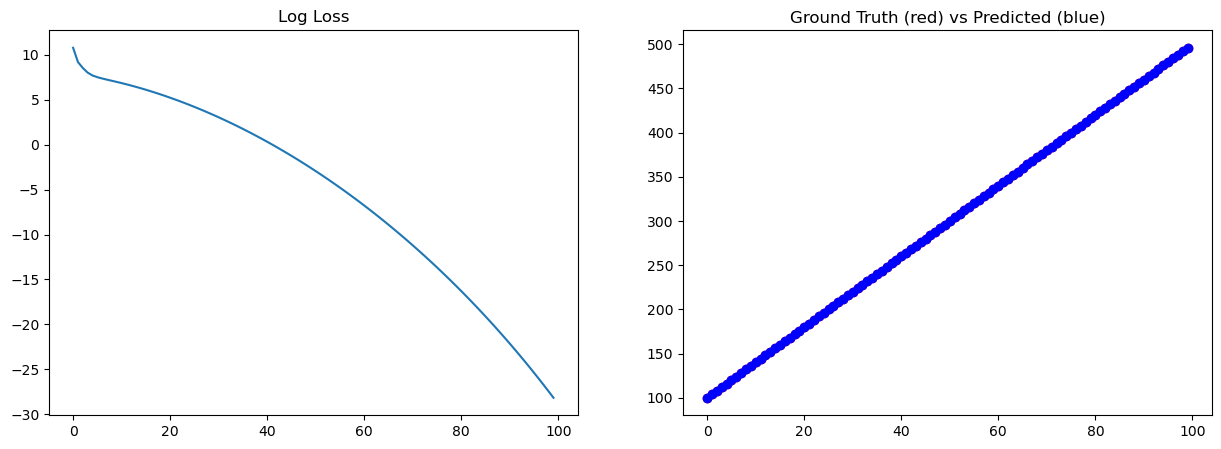

In [4]:
model = SLP1()
criterion = MSE("mean squared error")
optimizer = Adam(model.parameters(), lr)

def train_regression(X, Y, model, criterion, optimizer):
    running_loss = []
    for epoch in range(epochs):
        out = model(X)

        loss = criterion(out, Y)

        loss.backward()

        optimizer.step()

        model.zero_grad()

        if epoch % 10 == 0:
            running_loss.append(np.log(loss))

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].set_title('Log Loss')
    axes[0].plot(np.arange(0, len(running_loss)), running_loss)
    axes[1].set_title('Ground Truth (red) vs Predicted (blue)')
    axes[1].scatter(X, Y, c='red')
    axes[1].scatter(X, out, c='blue')

train_regression(X, Y, model, criterion, optimizer)

## SLP: Polynomial Regression

In [5]:
class SLP2(Network):
    def __init__(self):
        self.linear1 = FullyConnected(1, 1)
    
    def forward(self, x):
        return self.linear1(x)

In [6]:
X = Tensor(np.arange(0, 100).reshape((100, 1)))
Y = Tensor(X**2 + 4*X + 100)

epochs = 1000
lr = 1

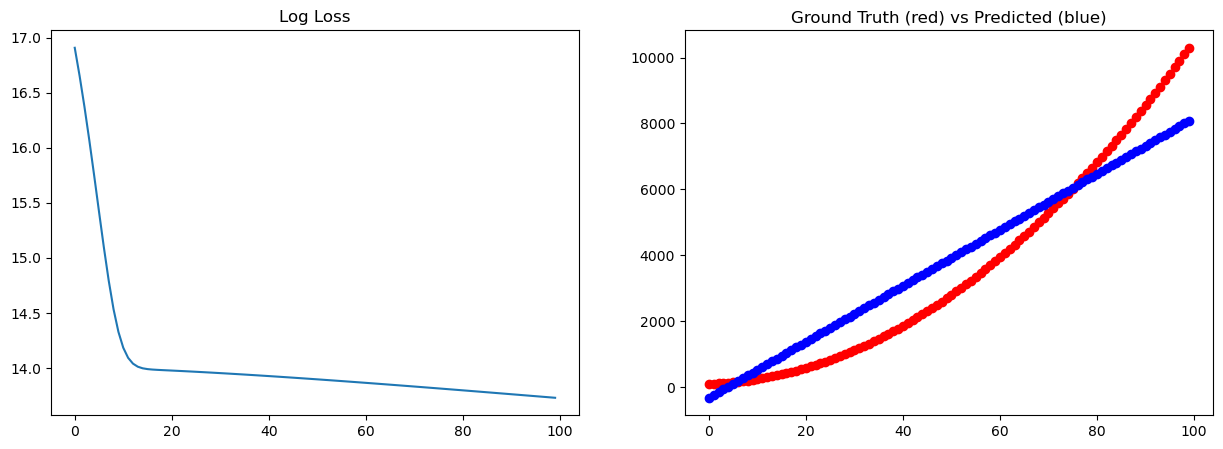

In [7]:
model = SLP2()
criterion = MSE("mean squared error")
optimizer = Adam(model.parameters(), lr)

train_regression(X, Y, model, criterion, optimizer)

## SLP: Polynomial Regression with Polynomial Feature Expansion

In [8]:
class SLP3(Network):
    def __init__(self):
        self.linear1 = FullyConnected(2, 1)
    
    def forward(self, X):
        X = Tensor(np.concatenate((X, X**2), axis=1))
        return self.linear1(X)

In [9]:
X = Tensor(np.arange(0, 100).reshape((100, 1)))
Y = Tensor(X**2 + 4*X + 100)

epochs = 1000
lr = 1

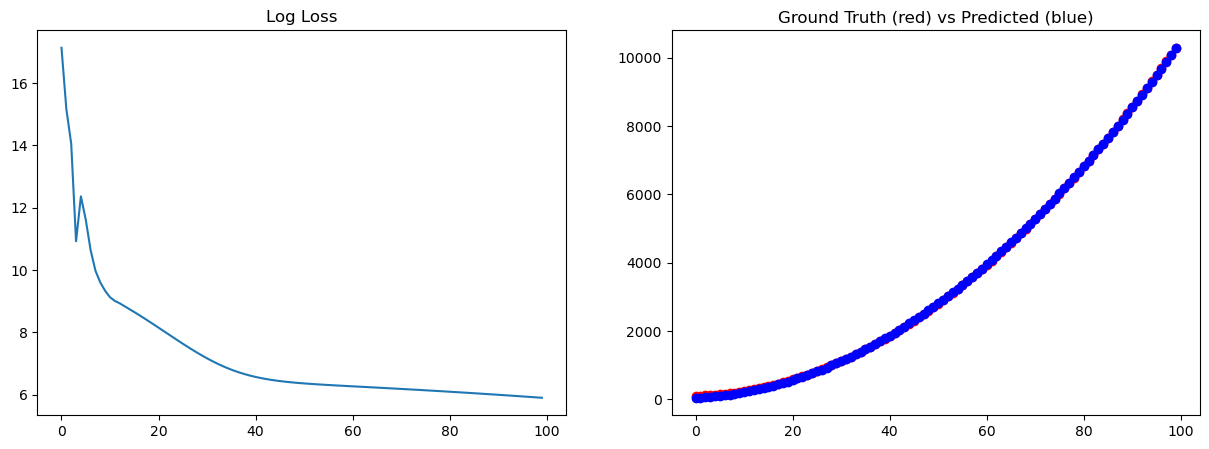

In [10]:
model = SLP3()
criterion = MSE("mean squared error")
optimizer = Adam(model.parameters(), lr)

train_regression(X, Y, model, criterion, optimizer)

## SLP: Sigmoid Regression

In [11]:
class SLP4(Network):
    def __init__(self):
        self.linear1 = FullyConnected(1, 1)
        self.sigmoid = Sigmoid()
    
    def forward(self, X):
        return self.sigmoid(self.linear1(X))

In [12]:
X = Tensor(np.arange(-10000, 10000).reshape((20000, 1)))
Y = Tensor(1 / (1 + np.exp(-X/100)))

epochs = 1000
lr = 0.03

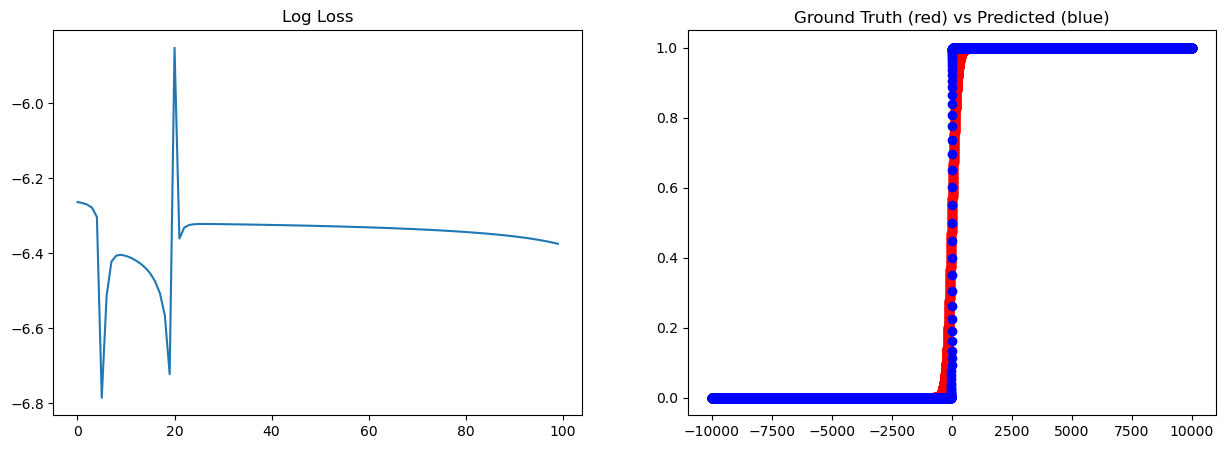

In [13]:
model = SLP4()
criterion = MSE("mean squared error")
optimizer = Adam(model.parameters(), lr)

train_regression(X, Y, model, criterion, optimizer)

# MLP

## MLP: Polynomial Regression

In [14]:
class MLP(Network):
    def __init__(self):
        self.linear1 = FullyConnected(1, 20)
        self.relu1 = ReLU()
        self.linear2 = FullyConnected(20, 20)
        self.relu2 = ReLU()
        self.linear3 = FullyConnected(20, 1)
    
    def forward(self, X):
        x = self.relu1(self.linear1(X))
        return self.linear3(self.relu2(self.linear2(x)))

In [15]:
X = Tensor(np.arange(-100, 100).reshape((200, 1)))
Y = Tensor(X**2 + 4*X + 100)

epochs = 1000
lr = 0.03

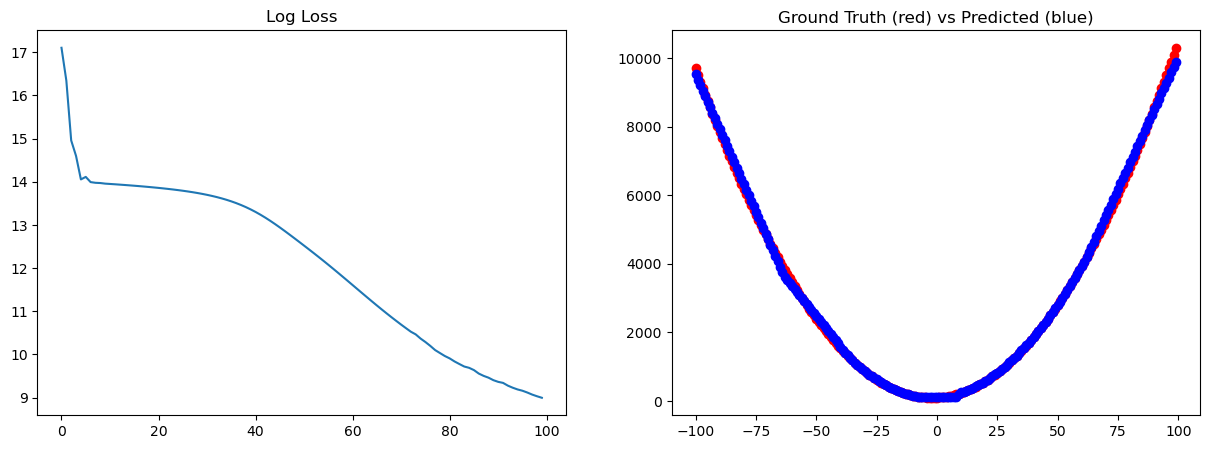

In [16]:
model = MLP()
criterion = MSE("mean squared error")
optimizer = Adam(model.parameters(), lr)

train_regression(X, Y, model, criterion, optimizer)

## MLP: Binary Classification

In [17]:
class BinaryClassifier(Network):
    def __init__(self):
        self.relu1 = ReLU()
        self.linear1 = FullyConnected(2, 16, weight_init="henormal", activation="relu")
        self.linear2 = FullyConnected(16, 1, weight_init="henormal", activation="sigmoid")

    def forward(self, X):
        return self.linear2(self.relu1(self.linear1(X)))

In [18]:
from sklearn.datasets import make_circles

X, y = make_circles(random_state=42)
X, y = Tensor(X), Tensor(y)

epochs = 1000
lr = 0.003

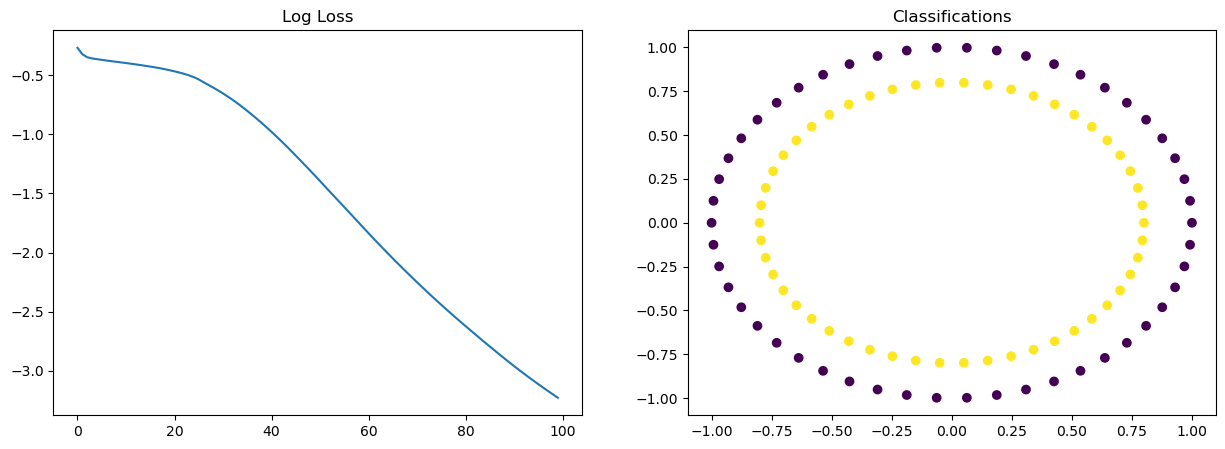

In [19]:
model = BinaryClassifier()
criterion = BinaryCrossEntropy("Binary Cross Entropy")
optimizer = Adam(model.parameters(), lr)

def train_classification(X, y, model, criterion, optimizer):
    running_loss = []
    for epoch in range(epochs):
        out = model(X)

        loss = criterion(out, y[:,None])

        loss.backward()

        optimizer.step()

        model.zero_grad()

        if epoch % 10 == 0:
            running_loss.append(np.log(loss))

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].set_title('Log Loss')
    axes[0].plot(np.arange(0, len(running_loss)), running_loss)
    axes[1].set_title('Classifications')
    axes[1].scatter(X[:,0], X[:,1], c=np.round(out))
            
train_classification(X, y, model, criterion, optimizer)

## MLP: Neural Field

In [25]:
def positional_encoding(coords, L):
    embeddings = [coords]
    for freq in 2.0 ** np.arange(L):
        embeddings.append(np.sin(freq * coords))
        embeddings.append(np.cos(freq * coords))

    # Concatenate all embeddings along the last dimension
    encoded_coords = np.concatenate(embeddings, axis=-1)  # Shape: (B, 4 * L)

    return Tensor(encoded_coords)

class NeuralField(Network):
    def __init__(self):
        self.linear1 = FullyConnected(42, 256, weight_init="henormal", activation="relu")
        self.relu1 = ReLU()
        self.linear2 = FullyConnected(256, 256, weight_init="henormal", activation="relu")
        self.relu2 = ReLU()
        self.linear3 = FullyConnected(256, 256, weight_init="henormal", activation="relu")
        self.relu3 = ReLU()
        self.linear4 = FullyConnected(256, 3, weight_init="henormal", activation="sigmoid")
        self.relu4 = ReLU()
        self.sigmoid = Sigmoid()
        
    def forward(self, X):
        x = positional_encoding(X, 10)
        x = self.relu1(self.linear1(x))
        x = self.relu2(self.linear2(x))
        x = self.relu3(self.linear3(x))
        x = self.linear4(x)
        return self.sigmoid(x)

In [41]:
class PixelDataset(Dataset):
    def __init__(self, im):
        self.H, self.W = im.shape[0], im.shape[1]
        self.u = np.stack(np.mgrid[:self.H, :self.W], axis=-1).reshape((self.H*self.W, 2)).astype(float)
        self.u[:,0] /= self.H
        self.u[:,1] /= self.W
        self.im = im.reshape(self.H*self.W, 3) / 255.0
        
    def __len__(self) -> int:
        return len(self.im)
    
    def __getitem__(self, idx):
        return Tensor(self.u[idx]), Tensor(self.im[idx])
    
epochs = 100
lr = 1e-3
batch_size = 1000

im = Image.open("./assets/fox.jpg")
new_size = tuple([int(dim * 0.2) for dim in im.size])
im = im.resize(new_size)
dataset = PixelDataset(Tensor(im))

dataloader = DataLoader(dataset, batch_size, shuffle=True)

In [42]:
model = NeuralField()
criterion = MSE("MSE error")
optimizer = Adam(model.parameters(), lr)

def train_regression(dataloader, model, criterion, optimizer):
    running_loss = []
    for epoch in range(epochs):
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            out = model(inputs)
            
            loss = criterion(out, targets)

            loss.backward()

            optimizer.step()

            model.zero_grad()

            print(np.log(loss))
    
train_regression(dataloader, model, criterion, optimizer)

-1.382753616002684
-1.461457513431684
-1.4789636272377231
-1.708503762613629
-1.9153285610945534
-1.948100712423285
-1.9596068041934078
-2.0080108930157996
-2.1990173665848305
-2.2284920675451425
-2.1810899454507076
-2.176420506629245
-2.201344762683283
-2.2707112569934313
-2.3303628138039434
-2.4036021907139826
-2.308774669403891
-2.3300090672560185
-2.3385517912070437
-2.347584936153734
-2.5474869324299076
-2.3429664736769493
-2.451806437306532
-2.3432436228947
-2.5182845753293974
-2.4124080666440513
-2.482126982742268
-2.5093519901072656
-2.531873177390093
-2.489497518898337
-2.597552080569479
-2.6003009397314876
-2.6825414547691477
-2.6068280198915983
-2.6061021419343002
-2.646961395187805
-2.675483947284246
-2.691590292601874
-2.627735301228597
-2.7862674475452973
-2.7259546787115223
-2.7327018128443332
-2.793175489151573
-2.831854998195904
-2.826904408276186
-2.8025978882883518
-2.9137525360038867
-2.877389743009994
-2.9699705718105367
-2.9012440547104035
-2.9305716566876177
-2.9

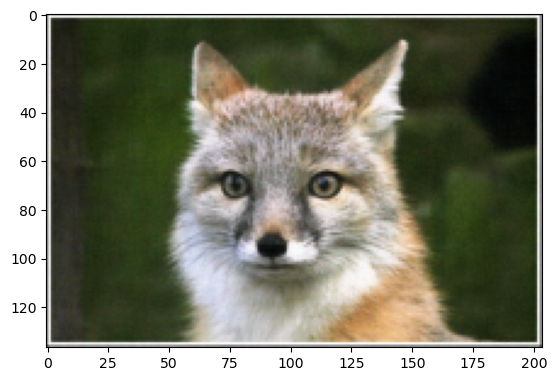

In [43]:
neural = model(dataset.u).reshape(dataset.H, dataset.W, -1)

plt.imshow(neural)